In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from IPython.display import display
%matplotlib inline

## Download KITTI
#### http://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=stereo

In [2]:
%%capture

# Download KITTI data
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_stereo_flow.zip && unzip data_stereo_flow.zip
!mkdir KITTI12
!mv training KITTI12
!mv testing KITTI12

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip && unzip data_scene_flow.zip
!mkdir KITTI15
!mv training KITTI15
!mv testing KITTI15

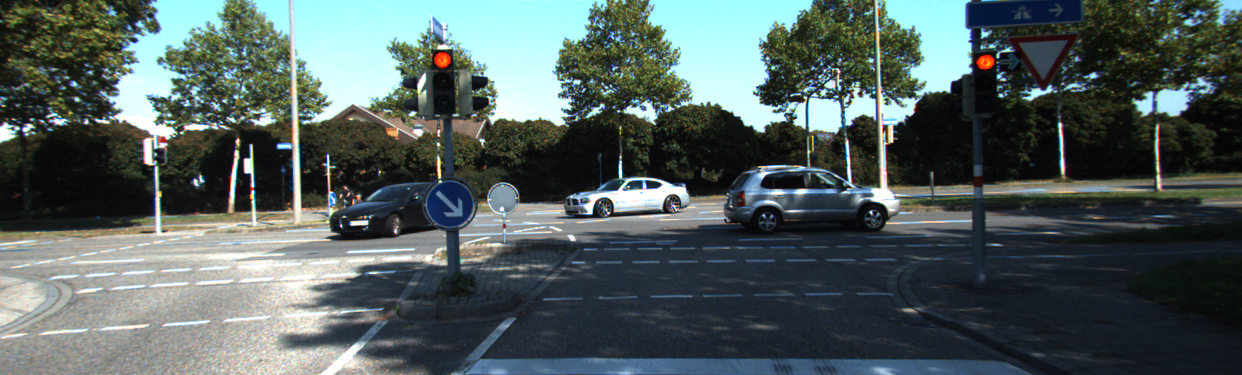

In [ ]:
# Visualize KITTI

img_id = 10
img = Image.open("./KITTI15/training/image_2/"+str(img_id).zfill(6)+"_10.png")
display(img)

## Create data loaders

In [4]:
import shutil
import os
for idx in range(194):
  img0_path = "KITTI12/training/colored_0/"+ str(idx).zfill(6) + "_10.png"
  img1_path = "KITTI12/training/colored_1/"+ str(idx).zfill(6) + "_10.png"
  gt_path ="KITTI12/training/disp_occ/"+ str(idx).zfill(6) + "_10.png"

  xidx = idx+200
  shutil.copy(img0_path , "KITTI15/training/image_2/"+ str(xidx).zfill(6) + "_10.png" )
  shutil.copy(img1_path , "KITTI15/training/image_3/"+ str(xidx).zfill(6) + "_10.png" )
  shutil.copy(gt_path , "KITTI15/training/disp_occ_0/"+ str(xidx).zfill(6) + "_10.png" )


In [5]:
class KITTI(Dataset):
    def __init__(self, path, transform=None, train = True):
        self.transform = transform
        self.img0_dir = path + "training/image_2/"
        self.img1_dir = path + "training/image_3/"
        self.gt_dir = path + "training/disp_occ_0/"
        self.train = train
        if train:
          self.size = int(len(os.listdir(self.gt_dir))*0.8)
        else:
          self.size = int(len(os.listdir(self.gt_dir))*0.2)
          self.remainder = int(len(os.listdir(self.gt_dir))*0.8)
          
        self.h = 256
        self.w = 512

    def __len__(self):
        return self.size
    def __getitem__(self, idx):
        if self.train:
          img0_path = self.img0_dir + str(idx).zfill(6) + "_10.png"
          img1_path = self.img1_dir + str(idx).zfill(6) + "_10.png"
          gt_path = self.gt_dir + str(idx).zfill(6) + "_10.png"
          img0 = Image.open(img0_path).convert('RGB')
          img1 = Image.open(img1_path).convert('RGB')
          gt = np.ascontiguousarray(Image.open(gt_path), dtype=np.float32)/256
          w,h  = img0.size
          self.r_h = random.randint(0,h-self.h)
          self.r_w = random.randint(0,w-self.w)
          img0 = img0.crop((self.r_w,self.r_h, self.r_w + self.w,self.r_h + self.h))
          img1 = img1.crop((self.r_w,self.r_h, self.r_w + self.w,self.r_h + self.h))
          gt =  gt[self.r_h:self.r_h+self.h, self.r_w:self.r_w + self.w ]
          if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
          return img0, img1, gt
        else:
          idx += self.remainder
          img0_path = self.img0_dir + str(idx).zfill(6) + "_10.png"
          img1_path = self.img1_dir + str(idx).zfill(6) + "_10.png"
          gt_path = self.gt_dir + str(idx).zfill(6) + "_10.png"
          img0 = Image.open(img0_path).convert('RGB')
          img1 = Image.open(img1_path).convert('RGB')
          w,h  = img0.size
          img0 = img0.crop((w-1232, h-368, w, h))
          img1 = img1.crop((w-1232, h-368, w, h))
          gt = Image.open(gt_path)
          gt = gt.crop((w-1232, h-368, w, h))
          gt = np.ascontiguousarray(gt,dtype=np.float32)/256
          if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
          return img0, img1, gt

In [6]:
normalize = {'mean': [0.485, 0.456, 0.406],
                   'std': [0.229, 0.224, 0.225]}
input_transforms = torchvision.transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(**normalize)])
test_dataset = KITTI('./KITTI15/', transform=input_transforms, train = False)
test_Loader = DataLoader(test_dataset, batch_size= 1, shuffle= False, num_workers= 4, drop_last=False)
print('Test Dataset Size:', len(test_dataset))

Test Dataset Size: 78


In [7]:
train_dataset = KITTI('./KITTI15/', transform=input_transforms,train=True)
train_loader = DataLoader(train_dataset, batch_size=4, pin_memory=True, shuffle=True, num_workers=4)

print('Train Dataset Size:', len(train_dataset))

Train Dataset Size: 315


## Create Basic Model

In [21]:
def conv_bn(dim, in_planes, out_planes, kernel_size, stride, pad, dilation=None):
  if dim == 2:
    return nn.Sequential(
        nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, stride=stride, padding=dilation if dilation > 1 else pad, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_planes)
    )
  elif dim == 3:
    return nn.Sequential(
        nn.Conv3d(in_channels=in_planes, out_channels=out_planes, kernel_size=kernel_size, padding=pad, stride=stride, bias=False),
        nn.BatchNorm3d(out_planes)
    )  

class BasicBlock(nn.Module):
  def __init__(self, in_planes, out_planes, stride, pad, dilation):
    super(BasicBlock, self).__init__()

    self.downsample = None
    self.stride = stride
    self.in_planes = in_planes
    self.out_planes = out_planes

    if stride != 1 or in_planes != out_planes:
        self.downsample = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_planes),
        )
    
    self.conv1 = nn.Sequential(
        conv_bn(2, in_planes, out_planes, 3, stride, pad=pad, dilation=dilation),
        nn.ReLU(inplace=True)
    )
    if dilation == 1:
        self.conv2 = nn.Sequential(conv_bn(2, out_planes, out_planes, (1,3), 1, (0,pad), dilation),
                                  conv_bn(2, out_planes, out_planes, (3,1), 1, (pad,0), dilation))
    else:
        self.conv2 = conv_bn(2, out_planes, out_planes, 3, 1, pad, dilation)

  def forward(self, x):
    out = self.conv2(self.conv1(x))
    if self.downsample:
      x = self.downsample(x)
    out += x

    return out

class DisparityRegression(nn.Module):
  def __init__(self, max_disp):
    super(DisparityRegression, self).__init__()
    self.disp = Variable(torch.Tensor(np.reshape(np.array(range(max_disp)), [1, max_disp, 1, 1])).cuda(), requires_grad=False)

  def forward(self, x):
    disp = self.disp.repeat(x.size()[0], 1, x.size()[2], x.size()[3])
    out = torch.sum(x*disp, 1)

    return out

class SPPModule(nn.Module):
    def __init__(self):
        super(SPPModule, self).__init__()
        self.in_planes = 32
        self.first_conv = nn.Sequential(conv_bn(2, 3, 32, 3, 2, 1, 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn(2, 32, 32, (1,3), 1, (0,1), 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn(2, 32, 32, (3,1), 1, (1,0), 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn(2, 32, 32, (1,3), 1, (0,1), 1),
                                       nn.ReLU(inplace=True),
                                       conv_bn(2, 32, 32, (3,1), 1, (1,0), 1),
                                       nn.ReLU(inplace=True))

        self.layer1 = self._make_layer(BasicBlock, 32, 3, 1, 1, 1)
        self.layer2 = self._make_layer(BasicBlock, 64, 16, 2, 1, 1) 
        self.layer3 = self._make_layer(BasicBlock, 128, 3, 1, 1, 1)
        self.layer4 = self._make_layer(BasicBlock, 128, 3, 1, 1, 2)

        self.branch1 = nn.Sequential(nn.AvgPool2d((64, 64), stride=(64, 64)),
                                     conv_bn(2, 128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch2 = nn.Sequential(nn.AvgPool2d((32, 32), stride=(32, 32)),
                                     conv_bn(2, 128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch3 = nn.Sequential(nn.AvgPool2d((16, 16), stride=(16, 16)),
                                     conv_bn(2, 128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.branch4 = nn.Sequential(nn.AvgPool2d((8, 8), stride=(8, 8)),
                                     conv_bn(2, 128, 32, 1, 1, 0, 1),
                                     nn.ReLU(inplace=True))

        self.last_conv = nn.Sequential(conv_bn(2, 320, 128, (1,3), 1, (0,1), 1),
                                      nn.ReLU(inplace=True),
                                      conv_bn(2, 128, 128, (3,1), 1, (1,0), 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(128, 32, kernel_size=1, padding=0, stride = 1, bias=False))

    def _make_layer(self, block, planes, blocks, stride, pad, dilation):
        layers = []
        layers.append(block(self.in_planes, planes, stride, pad, dilation))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, 1, pad, dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.first_conv(x)
        output = self.layer1(output)
        output_raw = self.layer2(output)
        output = self.layer3(output_raw)
        output = self.layer4(output)

        output_branch1 = self.branch1(output)
        output_branch1 = F.interpolate(output_branch1, (output.size()[2], output.size()[3]), mode='bilinear', align_corners=False)

        output_branch2 = self.branch2(output)
        output_branch2 = F.interpolate(output_branch2, (output.size()[2], output.size()[3]), mode='bilinear', align_corners=False)

        output_branch3 = self.branch3(output)
        output_branch3 = F.interpolate(output_branch3, (output.size()[2], output.size()[3]), mode='bilinear', align_corners=False)

        output_branch4 = self.branch4(output)
        output_branch4 = F.interpolate(output_branch4, (output.size()[2], output.size()[3]), mode='bilinear', align_corners=False)

        output_feature = torch.cat((output_raw, output, output_branch4, output_branch3, output_branch2, output_branch1), 1)
        output_feature = self.last_conv(output_feature)

        return output_feature

In [22]:

class PSMNet(nn.Module):
  def __init__(self, max_disp):
    super(PSMNet, self).__init__()
    self.maxdisp = max_disp
    self.feature_extraction = SPPModule()

    self.res0 = nn.Sequential(
      conv_bn(3, 64, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True)
    )
    self.res1 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1),
    )
    self.res2 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      conv_bn(3, 32, 32, 3, 1, 1)
    )
    self.res3 = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True), 
      conv_bn(3, 32, 32, 3, 1, 1)
    )
    self.classify = nn.Sequential(
      conv_bn(3, 32, 32, 3, 1, 1),
      nn.ReLU(inplace=True),
      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1, bias=False)
    )

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
        m.weight.data.normal_(0, np.sqrt(2. / n))
      elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        m.bias.data.zero_()

  def forward(self, left, right):
    ref_img_fea = self.feature_extraction(left)
    target_img_fea  = self.feature_extraction(right)

    cost = Variable(torch.FloatTensor(ref_img_fea.size()[0], ref_img_fea.size()[1]*2, self.maxdisp//4,  ref_img_fea.size()[2],  ref_img_fea.size()[3]).zero_(), volatile= not self.training).cuda()

    for i in range(self.maxdisp//4):
      if i > 0:
        cost[:, :ref_img_fea.size()[1], i, :,i:] = ref_img_fea[:,:,:,i:]
        cost[:, ref_img_fea.size()[1]:, i, :,i:] = target_img_fea[:,:,:,:-i]
      else:
        cost[:, :ref_img_fea.size()[1], i, :,:] = ref_img_fea
        cost[:, ref_img_fea.size()[1]:, i, :,:] = target_img_fea
    cost = cost.contiguous()

    cost0 = self.res0(cost)
    cost0 = self.res1(cost0) + cost0
    cost0 = self.res2(cost0) + cost0 
    cost0 = self.res3(cost0) + cost0 

    cost = self.classify(cost0)
    cost = F.interpolate(cost, [self.maxdisp,left.size()[2], left.size()[3]], mode='trilinear', align_corners=False)
    cost = torch.squeeze(cost, 1)
    pred = F.softmax(cost)
    pred = DisparityRegression(self.maxdisp)(pred)

    return pred

## Train Model

In [ ]:
# Define network and training parameters
torch.cuda.empty_cache()
model = PSMNet(192)
device = torch.device("cuda")
model.to(device)
print(model)

num_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [24]:
def Test_Acc(model2,test_loader):
  def test(imgL,imgR,disp_true):

        model2.eval()
        imgL   = Variable(torch.FloatTensor(imgL))
        imgR   = Variable(torch.FloatTensor(imgR))   
        imgL, imgR = imgL.cuda(), imgR.cuda()

        with torch.no_grad():
            output3 = model2(imgL,imgR)

        pred_disp = output3.data.cpu()
        true_disp = disp_true.clone()
        
        array = np.zeros(true_disp.shape)
        array[true_disp>0] = 1

        greater_than_one = len(array[array==1])

        disp_true = np.abs(true_disp-pred_disp.numpy())
        disp_true = disp_true*array
        error = len(disp_true[disp_true>3])

        return float(error)/float(greater_than_one)

  Error = []
  for i, (imgL, imgR, disp_L) in enumerate(test_Loader):
        Error.append(1-test(imgL,imgR,disp_L))

  print(f'Final Accuracy: {np.mean(np.array(Error))}')
  return np.mean(np.array(Error))

In [ ]:
# Train loop
import time
import numpy as np
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
model.train()
avg_loss = []
start_time = time.time()
Acc = []
for epoch in range(num_epochs):
    total_train_loss = 0
    for i, (imgL, imgR, disp_L) in enumerate(train_loader):
      imgL = Variable(torch.FloatTensor(imgL)).to(device)
      imgR = Variable(torch.FloatTensor(imgR)).to(device)   
      disp_L = Variable(torch.FloatTensor(disp_L)).to(device)
      
      mask = (disp_L > 0)
      mask.detach_()

      optimizer.zero_grad()
      out = model(imgL, imgR)
      out = torch.squeeze(out, 1)
      loss = F.smooth_l1_loss(out[mask], disp_L[mask], size_average=True)

      loss.backward()
      optimizer.step()
      avg_loss.append(loss.item())
      if i%5==0:
        print('Epoch: {0}, Iter: {1}, Training Loss: {2}'.format(epoch, i, loss))

      total_train_loss += loss.item()

      torch.cuda.empty_cache()
      del imgL
      del imgR
      del disp_L
      del out
      del loss


    scheduler.step(np.mean(avg_loss))
    print(f'Scheduler saw loss: {np.mean(avg_loss)}')
    print(f'Time: {(time.time()-start_time)/60} \n') 
    model.eval()
    Acc.append(Test_Acc(model,test_Loader))
    model.train()
    if epoch % 10 == 0:
      print(f'Saving the model at Epoch: {epoch}, Average Loss: {np.mean(avg_loss)} as Model_V2_Epoch_{epoch}')
      torch.save(model.state_dict(), f'Model_V2_Epoch_{epoch}.pt')
    avg_loss = []



In [ ]:
torch.save(model.state_dict(), 'model_V3_Epoch_30_Iter_60.pt')

In [ ]:
model2 = PSMNet(192)
model2.load_state_dict(torch.load('model_V1_Epoch_86.pt'));
model2.eval()
device = torch.device("cuda")
model2.to(device)

In [ ]:
Test_Acc(model,test_loader)

In [ ]:
from google.colab import files
files.download('model_V2_Epoch_25.pt')

In [ ]:
!nvidia-smi

Mon Nov  9 14:48:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    40W / 250W |  10681MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Visualize Result

In [ ]:
class KITTI_submission(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.img0_dir = path + "training/image_2/"
        self.img1_dir = path + "training/image_3/"
        self.gt_dir = path + "training/disp_occ_0/"
        self.size = int(len(os.listdir(self.gt_dir))*0.2)
        self.remainder = int(len(os.listdir(self.gt_dir))*0.8)
    def __len__(self):
        return self.size
    def __getitem__(self, idx):
          idx += self.remainder
          img0_path = self.img0_dir + str(idx).zfill(6) + "_10.png"
          img1_path = self.img1_dir + str(idx).zfill(6) + "_10.png"
          gt_path = self.gt_dir + str(idx).zfill(6) + "_10.png"
          img0 = Image.open(img0_path).convert('RGB')
          img1 = Image.open(img1_path).convert('RGB')
          w,h  = img0.size
          img0 = img0.crop((w-1232, h-368, w, h))
          img1 = img1.crop((w-1232, h-368, w, h))
          gt = Image.open(gt_path)
          gt = gt.crop((w-1232, h-368, w, h))
          gt = np.ascontiguousarray(gt,dtype=np.float32)/256
          if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
          return img0, img1, gt

In [ ]:
normalize = {'mean': [0.485, 0.456, 0.406],
                   'std': [0.229, 0.224, 0.225]}
input_transforms = torchvision.transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(**normalize)])
submission_dataset = KITTI('./KITTI/', transform=input_transforms)
submission_loader = DataLoader(submission_dataset, batch_size= 1, shuffle= False, num_workers= 4, drop_last=False)
print('Test Dataset Size:', len(test_dataset))

In [ ]:
def predict(i, imgL,imgR, DispL):

    model.eval()
    imgL   = Variable(torch.FloatTensor(imgL))
    imgR   = Variable(torch.FloatTensor(imgR))   
    imgL, imgR = imgL.cuda(), imgR.cuda()

    with torch.no_grad():
        output3 = model(imgL,imgR)

    pred_disp = np.squeeze(output3.data.cpu().numpy())
    true_disp = np.squeeze(DispL.data.cpu().numpy())
    
    pred_disp = Image.fromarray((pred_disp*256).astype('uint16'))
    pred_disp.save("pred/"+str(i)+".png")
    
    true_disp = Image.fromarray((true_disp*256).astype('uint16'))
    true_disp.save("GT/" + str(i)+".png")

In [ ]:
for i, (imgL, imgR, DispL) in enumerate(submission_loader):
    print("Inferring",i)
    predict(i, imgL, imgR, DispL)

In [ ]:
test_img_id = 16
test_gt = Image.open("./kitti_stereo2012/training/disp_occ/"+str(test_img_id).zfill(6)+"_10.png")
display(test_gt)